# Nerf explanation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmosZhu/Dizhong_PythonUtils/blob/main/Notebooks/Nerual_Scene/Nerf.ipynb)
[![Open In nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/AmosZhu/Dizhong_PythonUtils/blob/main/Notebooks/Nerual_Scene/Nerf.ipynb?flush_cache=True)

This notebook will explain following ideas from NERF which include
- Raymarching equation in paper.
- Weigthed ray sampler.

What not cover:
- Positional encoding. (Which is crucial for quality of NERF, I explained in another notebook.)
- Rendering.

## 1. Raymarching equation
\begin{equation}
    C=\sum_{i=1}^{N} T_i \alpha_i c_i
\end{equation}
It tells the pixel color on the image is the integral of the color along the ray.
As in discrete world, we take $N$ sample along the ray, and in each ray sample position, it contains color and weight. The final color of this ray in image pixel is their weighted sum up.

### $\alpha$-The light contribution
**$\alpha_i$** define how much light contribute to the final output in this sample. And it is defined by
\begin{equation}
    \alpha_i=1-e^{-\sigma_i \delta t_i}
\end{equation}
Where $\sigma$ is the surface density predict by Nerf, and $t_i$ is the distance between sample $i+1$ and $i$.

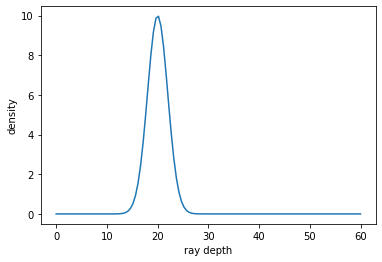

In [61]:
import numpy as np
import matplotlib.pyplot as plt


def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


x_values = np.linspace(0, 60, 120)
density = gaussian(x_values, mu=20, sig=2) * 10

plt.plot(x_values, density)
plt.xlabel('ray depth')
plt.ylabel('density')
plt.show()

Where the density should be high nearby surface and 0 where there is no object. Intuitively, we should say that pixel color was most contribute by the surface. So let's plot what corresponding $alpha$ should looks like.

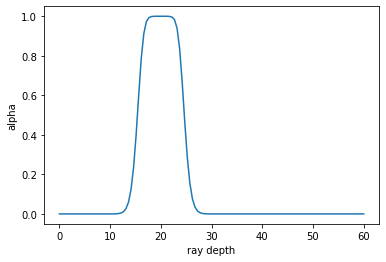

In [62]:
alpha_fun = lambda x: 1 - np.exp(-x)

alpha = alpha_fun(density)
plt.plot(x_values, alpha)
plt.xlabel('ray depth')
plt.ylabel('alpha')
plt.show()

You see the prediction density could be arbitrary value, but $\alpha$ make sure them normalise between $[0,1]$ and soft the density.

### $T$ - The surface opacity
While we see the $\alpha$ already played a role of weight that surface, then why we need $T$. Because a ray will penetrate multiple surfaces, the light energy will likely to decrease.

For example: a ray hit a solid surface then the objects behind the solid object should have very low(0) contribution to the final color. While the objects behind still has a high density though.

The definition of the light blockage is
\begin{equation}
    T_i=\prod_{k=1}^{k=i}(1-\alpha_k)
\end{equation}
Let's make up such a scenario.


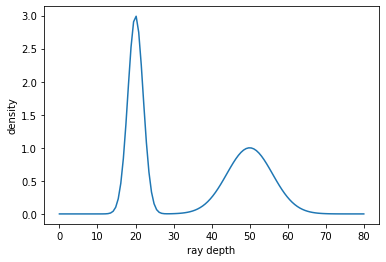

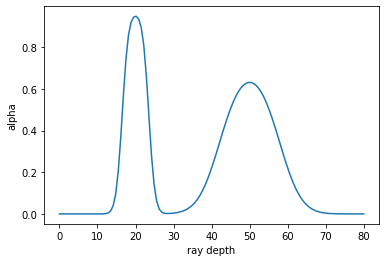

In [63]:
x_values = np.linspace(0, 80, 120)
y_values_1 = gaussian(x_values, mu=20, sig=2) * 3
# plt.plot(x_values, y_values)

y_values_2 = gaussian(x_values, mu=50, sig=6)

density = y_values_1 + y_values_2
plt.plot(x_values, density)
plt.xlabel('ray depth')
plt.ylabel('density')
plt.show()

alpha = alpha_fun(density)

plt.plot(x_values, alpha)
plt.xlabel('ray depth')
plt.ylabel('alpha')
plt.show()

Let's see what the T suppose like.

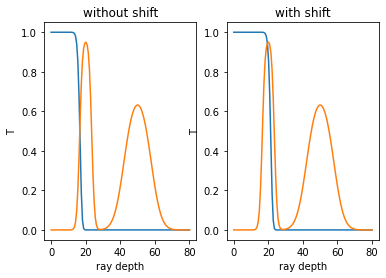

In [64]:
def _shifted_cumprod(x, shift: int = 1):
    x_cumprod = np.cumprod(x)
    x_cumprod_shift = np.concatenate(
        [np.ones_like(x_cumprod[..., :shift]), x_cumprod[..., :-shift]]
    )
    return x_cumprod_shift


T = _shifted_cumprod(1 - alpha)
plt.subplot(1, 2, 1)
plt.plot(x_values, T)
plt.plot(x_values, alpha)
plt.xlabel('ray depth')
plt.ylabel('T')
plt.title('without shift')

T = _shifted_cumprod(1 - alpha, shift=8)
plt.subplot(1, 2, 2)
plt.plot(x_values, T)
plt.plot(x_values, alpha)
plt.xlabel('ray depth')
plt.ylabel('T')
plt.title('with shift')

plt.show()

As you see, we also shift the function $T$ a little to make the light blockage after the highest density of the surface. You can see above figure when there is no shift, the $T_i=0$ when density is the highest, we might want to avoid it.


### The weight of color in each sample
So the weight of color in each sample is $w_i=\alpha_i \cdot T_i$. We use above example to see what it looks like.

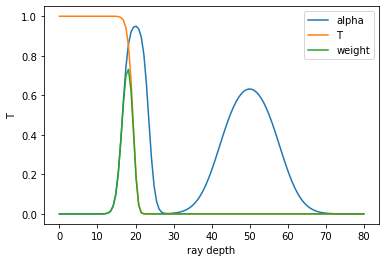

In [65]:
x_values = np.linspace(0, 80, 120)
y_values_1 = gaussian(x_values, mu=20, sig=2) * 3
y_values_2 = gaussian(x_values, mu=50, sig=6)

density = y_values_1 + y_values_2
alpha = alpha_fun(density)
T = _shifted_cumprod(1 - alpha, shift=5)
W = alpha * T

plt.plot(x_values, alpha)
plt.plot(x_values, T)
plt.plot(x_values, W)
plt.xlabel('ray depth')
plt.ylabel('T')
plt.legend(['alpha', 'T', 'weight'])
plt.show()

It's what we expected, the foremost surface dominant the weight of the color contribution.

## 2. Ray sampler by density.